In [1]:
#######################################################
##                  Module Contents                  ##
#######################################################

## Import packages used in analysis script:
import numpy as np
from matplotlib.pyplot import *
import glob
import os
import datetime
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from random import sample
from astropy.time import Time
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import pytz
import bisect
import pygeodesy
from mpl_toolkits import mplot3d
import pandas
from scipy.interpolate import interpn


## Define directories that contain modules/files of interest:
working_directory=u"/Users/wct9/python/"
drone_mod_directory=u'/Users/wct9/python/dronehacks/'
bico_beam_ECo_directory='/Users/wct9/python/Bicolog_Beam_EK_ECo/'
bico_beam_HCo_directory='/Users/wct9/python/Bicolog_Beam_EK_HCo/'

In [2]:
class Bicolog_Beam:
    def __init__(self,SParameter='S21'):
        print('Initialized Antenna Mapping Class: "Beam" loading file "data_{}.csv"'.format(SParameter))
        ## Load pandas DataFrame from .csv files stored in their respective directories for E,H polarizations:
        self.ECo_DF=pandas.read_csv(bico_beam_ECo_directory+'data_{}.csv'.format(SParameter),delimiter=',',skiprows=[62])
        self.HCo_DF=pandas.read_csv(bico_beam_HCo_directory+'data_{}.csv'.format(SParameter),delimiter=',',skiprows=[62])
        ## Extract freq and angle arrays from the dataframes:
        self.df_angle=np.append(np.array(self.ECo_DF['Angle'])[:61],np.array(self.ECo_DF['Angle'])[61:]+360.0)
        self.df_freq=np.array(self.ECo_DF.columns[1:]).astype(float)
        ## Create ndarrays of complex E,H polarization beams:
        self.complex_E_beam=np.array(self.ECo_DF,dtype=complex)[:,1:]
        self.complex_H_beam=np.array(self.HCo_DF,dtype=complex)[:,1:]
        ## Create array for dependent vars (phi[0,2pi](azimuth),theta[0,pi](altitude)) and frequency: 
        self.azimuth=np.linspace(0,360,360) # [0,2pi] every step 1 deg
        self.altitude=np.linspace(0,180,180)  # [0,pi] every step 1 deg
        self.D_ptf_t=np.zeros((len(self.azimuth),len(self.altitude),len(self.df_freq))) # az, alt, freq axes
        ## INTERPOLATE S21 for the E beam over our new 'altitude' array:
        ## Also want to normalize the values at 0,0 in order to avoid discontinuities:
        HtoEnorm_f=np.absolute(self.complex_E_beam[0,:])/np.absolute(self.complex_H_beam[0,:])
        alt_out=np.outer(self.altitude,np.ones(len(self.df_freq)))
        ## What we want to get out after looping over frequencies: 
        E_plus_out=np.zeros(alt_out.shape)
        H_plus_out=np.zeros(alt_out.shape)
        E_minus_out=np.zeros(alt_out.shape)
        H_minus_out=np.zeros(alt_out.shape)
        ## For E_plus and H_plus, the angle ranges are straightforward: [0,180]
        alt_plus_in=np.outer(self.df_angle[:61],np.ones(len(self.df_freq)))
        E_plus_in=np.absolute(self.complex_E_beam[:61,:])
        H_plus_in=np.absolute(self.complex_H_beam[:61,:])*HtoEnorm_f # now zero degeneracy for zenith pointing
        ## For E_minus and H_minus, the angle ranges change: [180,360]
        alt_minus_in=np.outer(np.append(self.df_angle[60:],self.df_angle[:1]+360.0),np.ones(len(self.df_freq)))
        E_minus_in=np.append(np.absolute(self.complex_E_beam[60:,:]),np.absolute(self.complex_E_beam[:1,:]),axis=0)
        H_minus_in=np.append(np.absolute(self.complex_H_beam[60:,:]),np.absolute(self.complex_H_beam[:1,:]),axis=0)*HtoEnorm_f
        ## Loop over frequencies so that the interpolation works properly:
        for i,f in enumerate(self.df_freq):
            E_plus_out[:,i]=np.interp(alt_out[:,i],alt_plus_in[:,i],E_plus_in[:,i])
            H_plus_out[:,i]=np.interp(alt_out[:,i],alt_plus_in[:,i],H_plus_in[:,i])
            E_minus_out[:,i]=np.interp(alt_out[::-1,i]+180.0,alt_minus_in[:,i],E_minus_in[:,i])
            H_minus_out[:,i]=np.interp(alt_out[::-1,i]+180.0,alt_minus_in[:,i],H_minus_in[:,i])
        ## What rotations should we use to map these data into our (L,T,Down)=(xyz) coordinate system?
            # These measurements are all the same E polarization! E/H is the theta axis convention.
            # Each previously computed slice in altitude corresponds to a fixed azimuth:
        self.D_ptf_t[0,:,:]=E_plus_out
        self.D_ptf_t[90,:,:]=H_plus_out
        self.D_ptf_t[180,:,:]=E_minus_out
        self.D_ptf_t[270,:,:]=H_minus_out
        ## Use cos and sin squared to sum the different slices for different azimuthal angles:
        for i,ang in enumerate(self.azimuth):
            EP=(np.cos(np.pi/180.0*ang).clip(min=0.0)**2.0)*E_plus_out
            HP=(np.sin(np.pi/180.0*ang).clip(min=0.0)**2.0)*H_plus_out
            EM=(np.cos(np.pi/180.0*(ang+180.0)).clip(min=0.0)**2.0)*E_minus_out
            HM=(np.sin(np.pi/180.0*(ang+180.0)).clip(min=0.0)**2.0)*H_minus_out
            self.D_ptf_t[i,:,:]=EP+HP+EM+HM
            
    def Interpolate_D_ptf(self,Az_arr,Alt_arr,Freq_arr):
        ## Assign coordinates for interpolation:
        AZ=Az_arr
        AL=Alt_arr
        FF=Freq_arr
        ## flatten so each interpolated point is (az,alt,freq) repeated as necessary:
        AZ_flat=np.outer(AZ,np.ones(len(FF))).flatten()
        AL_flat=np.outer(AL,np.ones(len(FF))).flatten()
        FF_flat=np.outer(np.ones(len(AZ)),FF).flatten()
        ## Define points, values, and interp point?
        points=(self.azimuth,self.altitude,self.df_freq) # tuple of the three axes [points]
        values=self.D_ptf_t                      # data values corresponding to points tuple with [az,alt,freq]
        ## Return the interpolated Directivity for input data:
        self.D_ptf_interp=interpn(points,values,(AZ_flat,AL_flat,FF_flat)).reshape((len(AL),len(FF)))

    def Plot_Beam_pcolormesh(self,Freq_ind=500):
        ##Define Coordinate Ranges for pcolormesh calls:
        X=np.outer(np.cos(np.pi/180.0*self.azimuth),np.sin(np.pi/180.0*self.altitude))
        Y=np.outer(np.sin(np.pi/180.0*self.azimuth),np.sin(np.pi/180.0*self.altitude))
        R=np.outer(np.ones(len(self.azimuth)),np.sin(np.pi/180.0*self.altitude))
        TH=np.outer(np.pi/180.0*self.azimuth,np.ones(len(self.altitude)))
        fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,7),subplot_kw=dict(projection="polar"))
        im1=ax1.pcolormesh(TH[:,0:60],R[:,0:60],self.D_ptf_t[:,0:60,Freq_ind],shading='auto')
        ax1.set_title(r'Front Facing Lobes [$\theta < \pi$][f={} MHz]'.format(float(self.df_freq[Freq_ind])/1e6))
        ax1.set_yticklabels([])
        fig.colorbar(im1,ax=ax1)
        im2=ax2.pcolormesh(TH[:,60:],R[:,60:],self.D_ptf_t[:,60:,Freq_ind],shading='auto')
        ax2.set_title(r'Back Facing Lobes [$\theta > \pi$][f={} MHz]'.format(float(self.df_freq[Freq_ind])/1e6))
        ax2.set_yticklabels([])
        fig.colorbar(im2,ax=ax2)
        tight_layout()

        
    def Plot_Beam_Profiles(self,Polarization='E',lb_ub_step_list=[0,-1,33],Overplot_R_and_I=True):
        ## Initialize Polar Figure:
        fig=figure(figsize=(17,10))
        ax1=fig.add_subplot(111,projection='polar')
        fig.suptitle('Bicolog Antenna Azimuthal Beam Profiles -- {} Polarization'.format(Polarization),fontsize='x-large')
        ax1.set_title('Magnitude')
        ## Choose the polarization data that is going to be plotted:
        if Polarization=='E':
            ddd=self.complex_E_beam
        elif Polarization=='H':
            ddd=self.complex_H_beam
        ## Choose the frequency indices to plot:
        [blb,bub,bstep]=lb_ub_step_list
        ## Create color array for looped plots of beam contours: ##
        CNorm=colors.Normalize()
        CNorm.autoscale(np.arange(len(self.df_freq))[blb:bub:bstep])
        CM=cm.gnuplot2
        ## Plot several contours for various frequencies: ##
        for ind in np.arange(len(self.df_freq))[blb:bub:bstep][1:-1]:
            ax1.plot(np.pi/180.0*np.append(self.df_angle,self.df_angle[0]),np.absolute(np.append(ddd[:,ind],ddd[:1,ind])),'.-',c=CM(CNorm(ind)),label='{} MHz'.format(float(self.df_freq[ind])/1e6))
        ax1.plot(np.linspace(0.0,2.0*np.pi,100),1.0*np.ones(100),'k--',label='Isotropic Radiator')
        ax1.legend(loc=4,ncol=3,fontsize='small',framealpha=1.0)
        ax1.set_rgrids([0,1,2], angle=90.0)
        ax1.set_thetagrids([0,90,180,270])
        ax1.set_rlim(0,2.75)
        ax1.set_xticklabels([])
        if Overplot_R_and_I==True:
            ax2=fig.add_subplot(221,projection='polar')
            ax3=fig.add_subplot(223,projection='polar')
            ax2.set_ylabel('Real Component')
            ax3.set_ylabel('Imaginary Component')
            for ind in np.arange(len(self.df_freq))[blb:bub:bstep][1:-1]:
                ax2.plot(np.pi/180.0*self.df_angle,np.real(ddd[:,ind]),'.',c=CM(CNorm(ind)))
                ax3.plot(np.pi/180.0*self.df_angle,np.imag(ddd[:,ind]),'.',c=CM(CNorm(ind)))
            for ax in [ax1,ax2,ax3]:
                ax.set_rgrids([0,1,2], angle=90.0)
                ax.set_thetagrids([0,90,180,270])
                ax.set_rlim(0,2.75)
                ax.set_xticklabels([])
        tight_layout()

Initialized Antenna Mapping Class: "Beam" loading file "data_S21.csv"


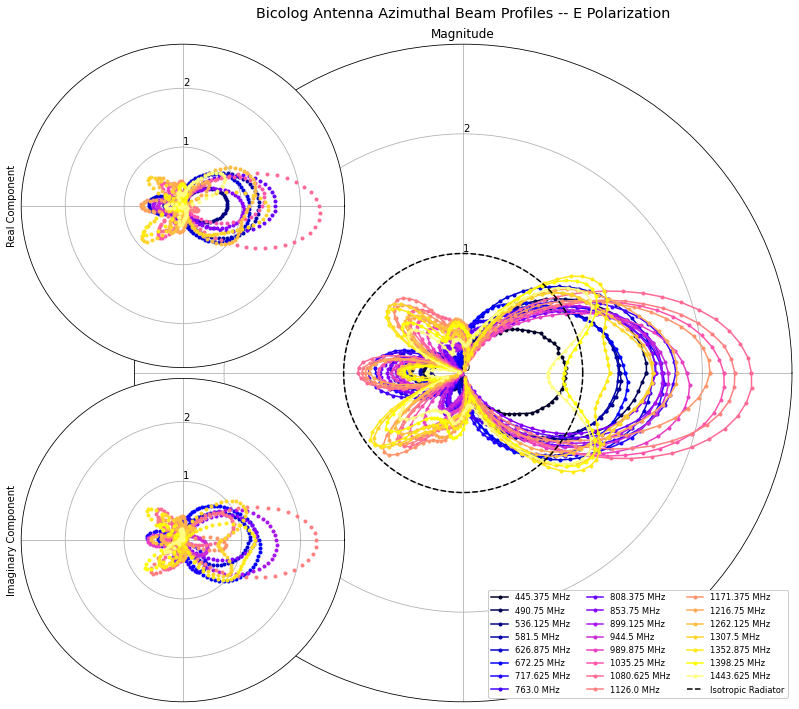

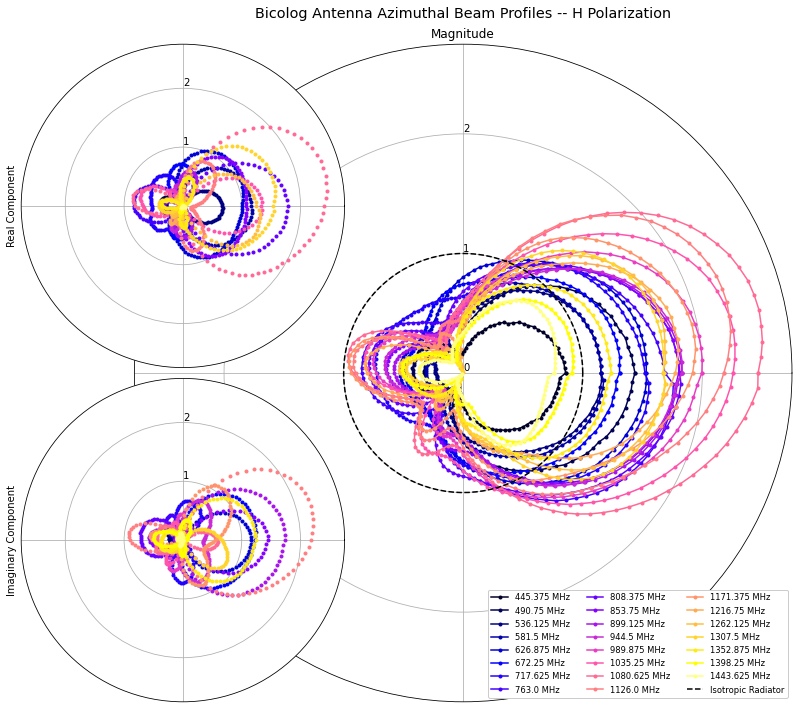

In [3]:
data=Bicolog_Beam()
data.Plot_Beam_Profiles(Polarization='E')
data.Plot_Beam_Profiles(Polarization='H')

/Users/wct9/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:81: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


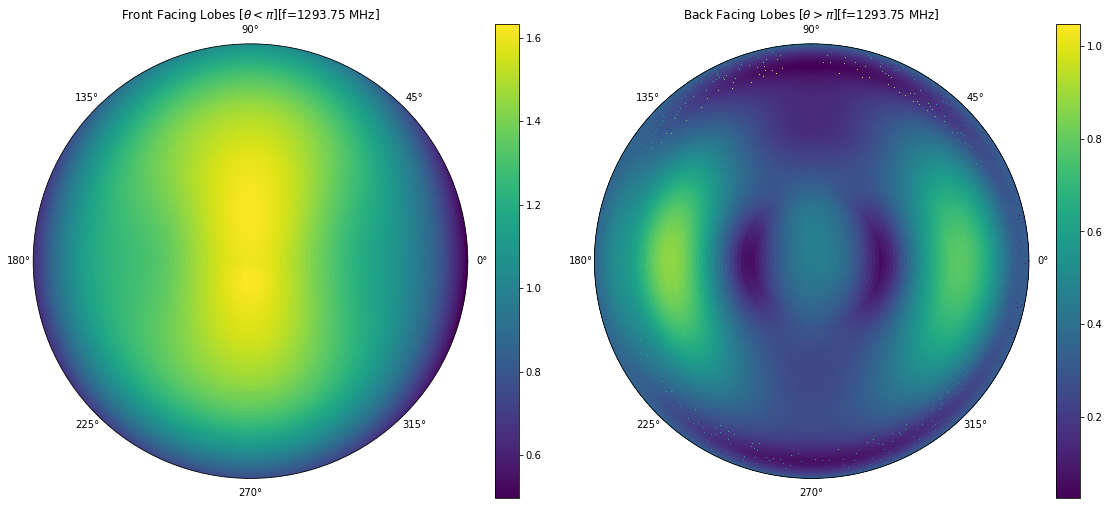

In [4]:
data.Plot_Beam_pcolormesh(Freq_ind=650)

In [5]:
## Test Interpolation Function:
tAZ=np.linspace(3,243,250)
tAL=np.linspace(0.2,13,250)
tFF=np.linspace(455e6,777e6,1000)

data.Interpolate_D_ptf(Az_arr=tAZ,Alt_arr=tAL,Freq_arr=tFF)
data.D_ptf_interp.shape

(250, 1000)

In [6]:
## OLD SHIT now that module works:
## Print linear and dB max values for the beam:
print('Elinmax',np.nanmax(np.absolute(data.complex_E_beam))) # 1 is value for isotropic radiator
print('Edbmax',np.nanmax(20.0*np.log10(np.absolute(data.complex_E_beam)))) #in dB, 0 is value for isotropic
print('Hlinmax',np.nanmax(np.absolute(data.complex_H_beam)))
print('Hdbmax',np.nanmax(20.0*np.log10(np.absolute(data.complex_H_beam))))

Elinmax 2.4734848730080055
Edbmax 7.8661851742203766
Hlinmax 2.5864252485862815
Hdbmax 8.253998623812773


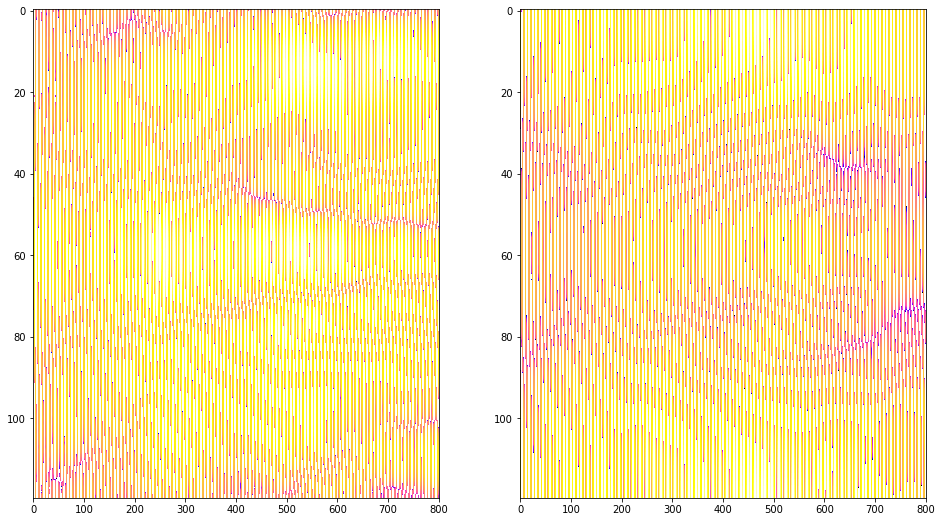

In [22]:
fig1,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,9))
im1=ax1.imshow(np.real(data.complex_E_beam-data.complex_H_beam),cmap='gnuplot2',aspect='auto',norm=LogNorm())
im2=ax2.imshow(np.imag(data.complex_H_beam),cmap='gnuplot2',aspect='auto',norm=LogNorm())

In [23]:
#################################
### Incorporating Drone Beam? ###
###        EMILY's CODE       ###
#################################

def lintodb(mags):
    mag_=20*np.log10(np.array(mags))
    return(mag_)
def dbtolin(mags):
    mag_ = 10**(np.array(mags)/20)
    return(mag_)
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
#Read in #S21 Data
def getangledata(frequency_input):
    fileset='S21.csv'
    allscans= np.sort(glob.glob(fileset))
    for i in range(len(allscans)):
        data = []
        angle = []
        with open(allscans[i], 'rt', encoding='utf8', errors='ignore') as f:
            reader = csv.reader(f)
            for row in reader:
    #             print(row)
                data.append(row)
                angle.append(row[0])
            frequency = [float(i) for i in data[0][1::]]
    freq = np.array(frequency)/1e6
    angle = angle[1::]
    for i in range(len(allscans)):
        data = []
        with open(allscans[i], 'rt', encoding='utf8', errors='ignore') as f:
            reader = csv.reader(f)
            for row in reader:
    #             print(row)
                data.append(row)
            angle0 = [i for i in data[1][1::]]
            freq = np.array(frequency)/1e6
            data_np = np.array(data)
            datafinal = data_np[1:-1]
    mags = []
    for j in range(len(data)):
        test = [abs(complex(i)) for i in data[j][1::]]
        mags.append(test)
    frequency_nearest = find_nearest(freq, frequency_input)
    frequency_index = list(freq).index(frequency_nearest)
    mags = mags[1::]
    angle = [float(i) for i in angle]
    mags_cfreq = [lintodb(np.array(mags[i][frequency_index])) for i in range(len(mags))]
    df = pd.DataFrame()
    df['angles'] = angle
    df['mag'] = mags_cfreq
    df['angles_rad'] = df['angles']*np.pi/180
    df = df.sort_values(by='angles')
    return(df)

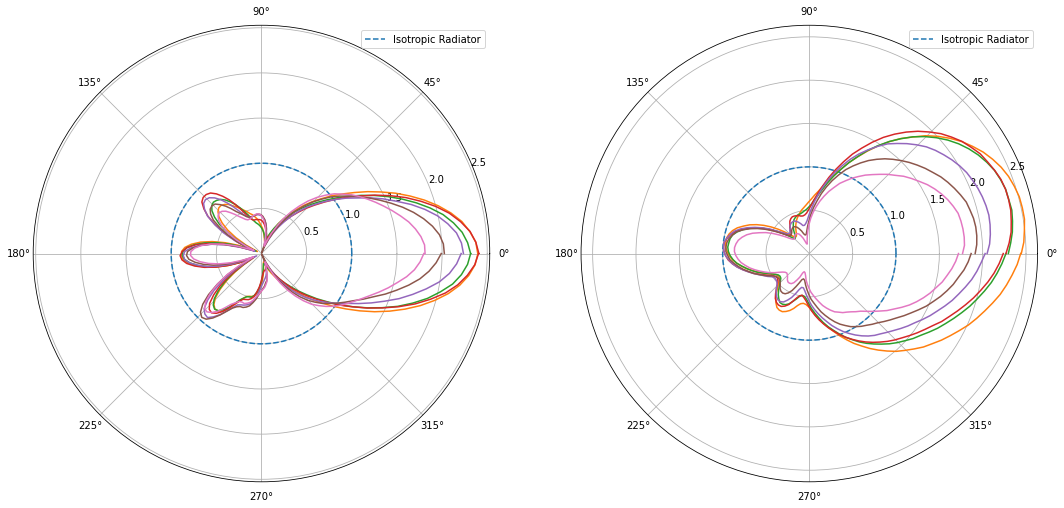

In [24]:
## Plot Abs(S21) per angle for both cuts with LINEAR scale on polar axis:
    ## This is the DIRECTIVITY D(theta,phi) function in linear scale
    ## (1.0 is value an isotropic radiator would have)
fig=figure(figsize=(18,9))
ax1=fig.add_subplot(121,projection='polar')
ax1.plot(np.linspace(0.0,2.0*np.pi,100),1.0*np.ones(100),'--',label='Isotropic Radiator')
ax1.plot(np.linspace(0,2*np.pi,120),np.absolute(data.complex_E_beam[:,500:600:17]))
ax2=fig.add_subplot(122,projection='polar')
ax2.plot(np.linspace(0.0,2.0*np.pi,100),1.0*np.ones(100),'--',label='Isotropic Radiator')
ax2.plot(np.linspace(0,2*np.pi,120),np.absolute(data.complex_H_beam[:,500:600:17]))
ax1.legend()
ax2.legend()

/Users/wct9/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/Users/wct9/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/wct9/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/Users/wct9/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


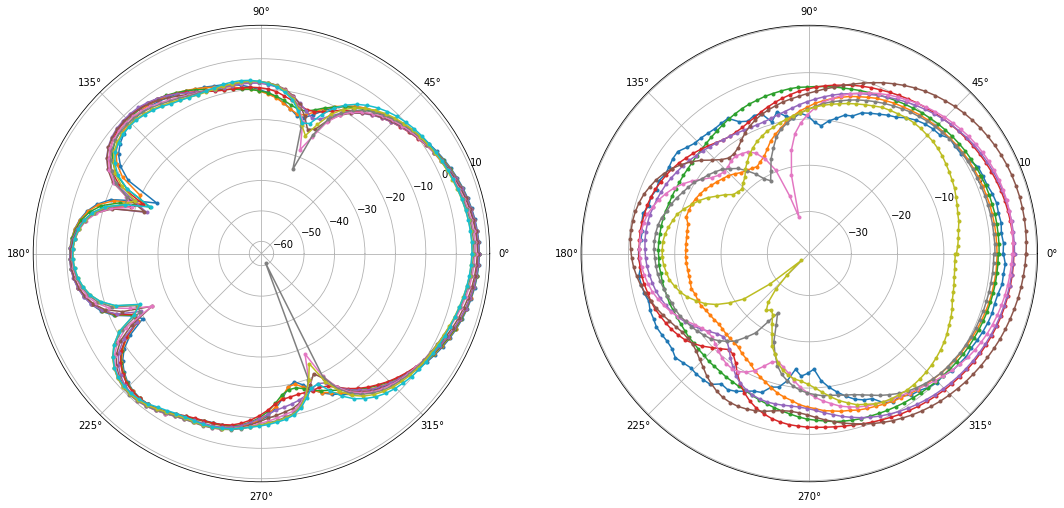

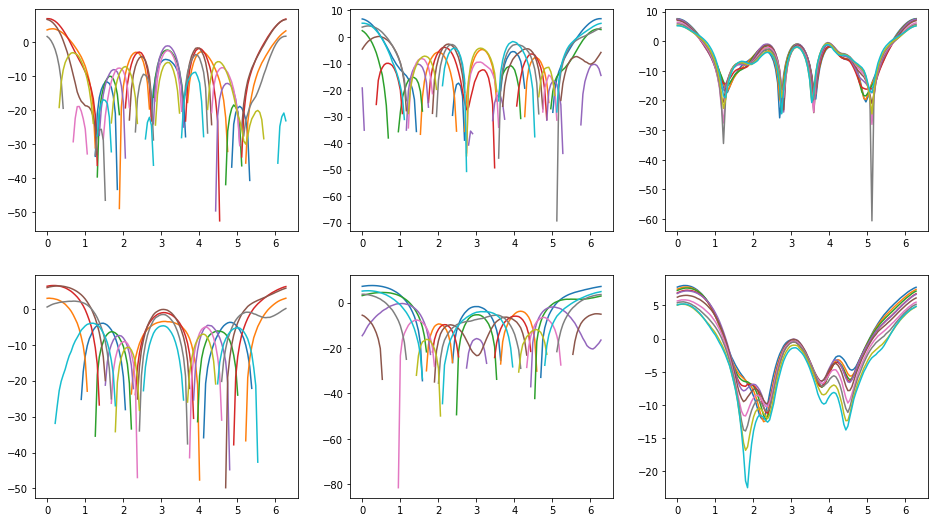

In [25]:
## Plot S21 in dB on polar axes:
fig=figure(figsize=(18,9))
ax1=fig.add_subplot(121,projection='polar')
ax1.plot(np.linspace(0,2*np.pi,120),20.0*np.log10(np.absolute(data.complex_E_beam[:,500:600:10])),'.-')
ax2=fig.add_subplot(122,projection='polar')
ax2.plot(np.linspace(0,2*np.pi,120),20.0*np.log10(np.absolute(data.complex_H_beam[:,::100])),'.-')

## Plot S21 in dB on cartesian axes just for fun:
fig1,[[ax1,ax2,ax3],[ax4,ax5,ax6]]=subplots(nrows=2,ncols=3,figsize=(16,9))
ax1.plot(np.linspace(0,2*np.pi,120),20.0*np.log10(np.real(data.complex_E_beam[:,500:600:10])))
ax2.plot(np.linspace(0,2*np.pi,120),20.0*np.log10(np.imag(data.complex_E_beam[:,500:600:10])))
ax3.plot(np.linspace(0,2*np.pi,120),20.0*np.log10(np.absolute(data.complex_E_beam[:,500:600:10])))
ax4.plot(np.linspace(0,2*np.pi,120),20.0*np.log10(np.real(data.complex_H_beam[:,500:600:10])))
ax5.plot(np.linspace(0,2*np.pi,120),20.0*np.log10(np.imag(data.complex_H_beam[:,500:600:10])))
ax6.plot(np.linspace(0,2*np.pi,120),20.0*np.log10(np.absolute(data.complex_H_beam[:,500:600:10])))

In [228]:
## WORK THAT IS NOW INTEGRATED INTO THE CLASS:
## Create array for the directivity as a function of (phi[0,2pi](azimuth),theta[0,pi](altitude)) and frequency: 
azimuth=np.linspace(0,360,360) # [0,2pi] every step 1 deg
altitude=np.linspace(0,180,180)  # [0,pi] every step 1 deg
D_ptf_t=np.zeros((len(azimuth),len(altitude),len(data.freq))) # az, alt, freq axes

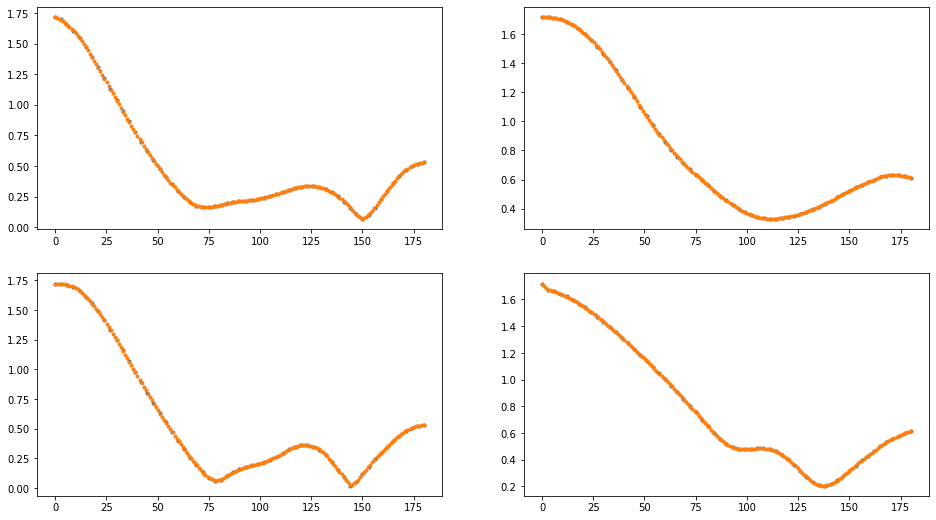

In [772]:
## Try interpolating S21 for the E beam over our new 'altitude' array:
## Also want to normalize the values at 0,0 in order to avoid discontinuities? Perhaps later...
HtoEnorm_f=np.absolute(data.complex_E_beam[0,:])/np.absolute(data.complex_H_beam[0,:])
alt_out=np.outer(altitude,np.ones(len(data.freq)))
## What we want to get out after looping over frequencies: 
E_plus_out=np.zeros(alt_minus_out.shape)
H_plus_out=np.zeros(alt_minus_out.shape)
E_minus_out=np.zeros(alt_minus_out.shape)
H_minus_out=np.zeros(alt_minus_out.shape)
## For E_plus and H_plus, the angle ranges are straightforward: [0,180]
alt_plus_in=np.outer(data.angle[:61],np.ones(len(data.freq)))
E_plus_in=np.absolute(data.complex_E_beam[:61,:])
H_plus_in=np.absolute(data.complex_H_beam[:61,:])*HtoEnorm_f # now zero degeneracy for zenith pointing
## For E_minus and H_minus, the angle ranges change: [180,360]
alt_minus_in=np.outer(np.append(data.angle[60:],data.angle[:1]+360.0),np.ones(len(data.freq)))
E_minus_in=np.append(np.absolute(data.complex_E_beam[60:,:]),np.absolute(data.complex_E_beam[:1,:]),axis=0)
H_minus_in=np.append(np.absolute(data.complex_H_beam[60:,:]),np.absolute(data.complex_H_beam[:1,:]),axis=0)*HtoEnorm_f
## Loop over frequencies so that the interpolation works properly:
for i,f in enumerate(data.freq):
    E_plus_out[:,i]=np.interp(alt_out[:,i],alt_plus_in[:,i],E_plus_in[:,i])
    H_plus_out[:,i]=np.interp(alt_out[:,i],alt_plus_in[:,i],H_plus_in[:,i])
    E_minus_out[:,i]=np.interp(alt_out[::-1,i]+180.0,alt_minus_in[:,i],E_minus_in[:,i])
    H_minus_out[:,i]=np.interp(alt_out[::-1,i]+180.0,alt_minus_in[:,i],H_minus_in[:,i])
    
## Plot these ins and outs to see if the interpolation has worked properly:
fig1,[[ax1,ax2],[ax3,ax4]]=subplots(nrows=2,ncols=2,figsize=(16,9))
ax1.plot(alt_plus_in[:,0],E_plus_in[:,400],'.')
ax2.plot(alt_plus_in[:,0],H_plus_in[:,400],'.')
ax3.plot(360-alt_minus_in[:,0],E_minus_in[:,400],'.') # 360-alt_minus_in gives correction to altitude angle
ax4.plot(360-alt_minus_in[:,0],H_minus_in[:,400],'.') # 360-alt_minus_in gives correction to altitude angle
ax1.plot(alt_out[:,0],E_plus_out[:,400],'.')
ax2.plot(alt_out[:,0],H_plus_out[:,400],'.')
ax3.plot(alt_out[:,0],E_minus_out[:,400],'.')
ax4.plot(alt_out[:,0],H_minus_out[:,400],'.')

1.7195671155240457 1.7195671155240457
1.8338878780621661 1.719567115524046


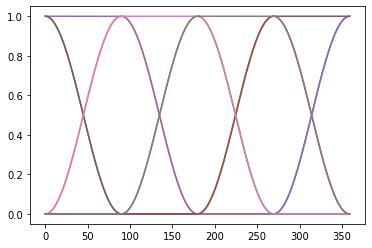

In [773]:
## What rotations should we use to map these data into our (L,T,Down)=(xyz) coordinate system?
    # These measurements are all the same E polarization! E/H is the theta axis convention.
    # Each previously computed slice in altitude corresponds to a fixed azimuth:
D_ptf_t[0,:,:]=E_plus_out
D_ptf_t[90,:,:]=H_plus_out
D_ptf_t[180,:,:]=E_minus_out
D_ptf_t[270,:,:]=H_minus_out

## Use cos and sin squared to sum the different slices for different azimuthal angles:
for i,ang in enumerate(azimuth):
    EP=(np.cos(np.pi/180.0*ang).clip(min=0.0)**2.0)*E_plus_out
    HP=(np.sin(np.pi/180.0*ang).clip(min=0.0)**2.0)*H_plus_out
    EM=(np.cos(np.pi/180.0*(ang+180.0)).clip(min=0.0)**2.0)*E_minus_out
    HM=(np.sin(np.pi/180.0*(ang+180.0)).clip(min=0.0)**2.0)*H_minus_out
    D_ptf_t[i,:,:]=EP+HP+EM+HM
    
## Plot the coefficients used to sum these up as a function of angle, just to prove the coefficients are ok:
plot(np.cos(np.pi/180.0*azimuth).clip(min=0.0)**2.0)
plot(np.sin(np.pi/180.0*azimuth).clip(min=0.0)**2.0)
plot(np.cos(np.pi/180.0*(azimuth+180)).clip(min=0.0)**2.0)
plot(np.sin(np.pi/180.0*(azimuth+180)).clip(min=0.0)**2.0)
plot(np.cos(np.pi/180.0*azimuth).clip(min=0.0)**2.0+np.sin(np.pi/180.0*azimuth).clip(min=0.0)**2.0)
plot(np.cos(np.pi/180.0*azimuth).clip(min=0.0)**2.0+np.sin(np.pi/180.0*(azimuth+180)).clip(min=0.0)**2.0)
plot(np.cos(np.pi/180.0*(azimuth+180)).clip(min=0.0)**2.0+np.sin(np.pi/180.0*azimuth).clip(min=0.0)**2.0)
plot(+np.cos(np.pi/180.0*(azimuth+180)).clip(min=0.0)**2.0+np.sin(np.pi/180.0*(azimuth+180)).clip(min=0.0)**2.0)

## Also good to show that these values are still equal after the loop assignment:
print(np.absolute(data.complex_E_beam[0,400]),D_ptf_t[0,0,400])
print(np.absolute(data.complex_H_beam[0,400]),D_ptf_t[90,0,400])
## Yes, they agree!

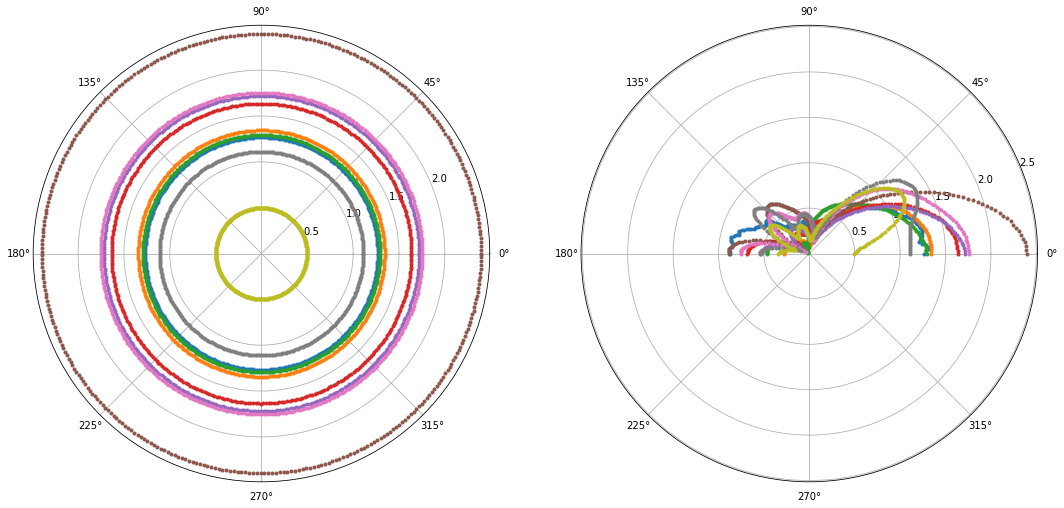

In [774]:
## Plot beam slices for some frequencies:
fig=figure(figsize=(18,9))
ax1=fig.add_subplot(121,projection='polar')
ax2=fig.add_subplot(122,projection='polar')
## Slice in azimuth (theta)
ax1.plot(azimuth/180*np.pi,D_ptf_t[:,0,::100],'.') # 0 in theta is IN beam direction azimuth isnt defined...?
## Slice in altitude (phi)
ax2.plot(altitude/180*np.pi,D_ptf_t[0,:,::100],'.') # 0 in phi is IN Eplius beam direction

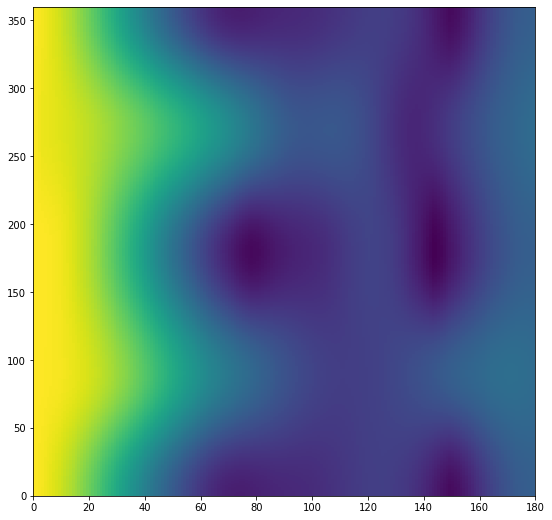

In [775]:
## Imshow or pcolormesh to see a beam pattern for some frequency:
fig=figure(figsize=(9,9))
ax1=fig.add_subplot(111)
ax1.pcolormesh(D_ptf_t[:,:,400],shading='auto')

In [776]:
##Define Coordinate Ranges for pcolormesh calls:
X=np.outer(np.cos(np.pi/180.0*azimuth),np.sin(np.pi/180.0*altitude))
Y=np.outer(np.sin(np.pi/180.0*azimuth),np.sin(np.pi/180.0*altitude))
R=np.outer(np.ones(len(azimuth)),np.sin(np.pi/180.0*altitude))
TH=np.outer(np.pi/180.0*azimuth,np.ones(len(altitude)))

/Users/wct9/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/wct9/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  


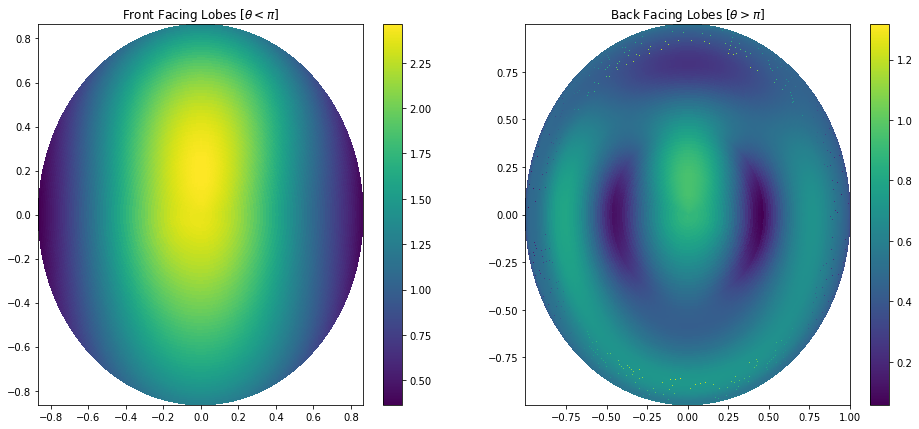

In [777]:
## I'd be curious to see how this looks in xyz where definitions would make sense...
fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,7))
im1=ax1.pcolormesh(X[:,0:60],Y[:,0:60],D_ptf_t[:,0:60,500],shading='auto')
ax1.set_title(r'Front Facing Lobes [$\theta < \pi$]')
fig.colorbar(im1,ax=ax1)
im2=ax2.pcolormesh(X[:,60:],Y[:,60:],D_ptf_t[:,60:,500],shading='auto')
ax2.set_title(r'Back Facing Lobes [$\theta > \pi$]')
fig.colorbar(im2,ax=ax2)


/Users/wct9/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  import sys


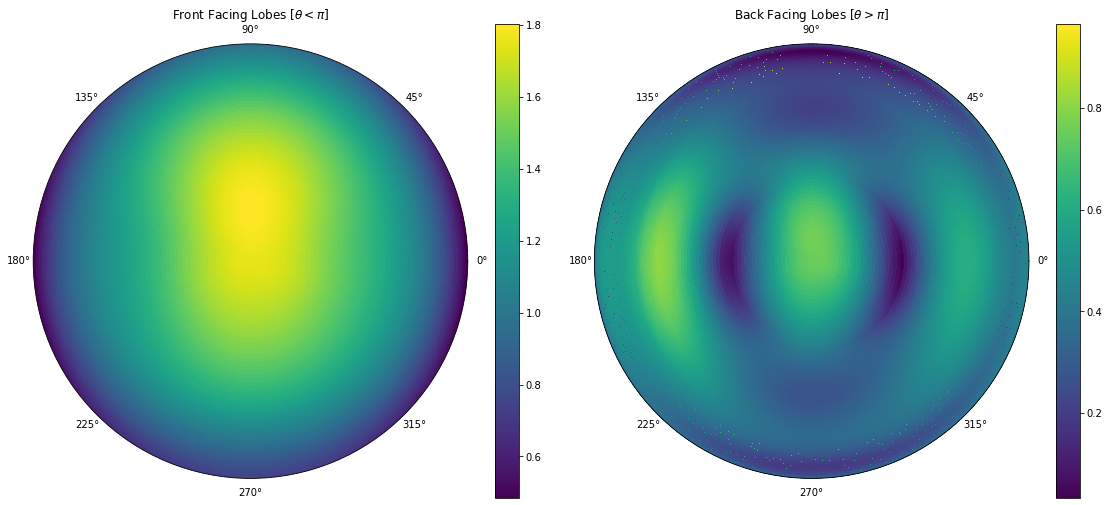

In [778]:
## I'd be curious to see how this looks in xyz where definitions would make sense...
fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,7),subplot_kw=dict(projection="polar"))
im1=ax1.pcolormesh(TH[:,0:60],R[:,0:60],D_ptf_t[:,0:60,600],shading='auto')
ax1.set_title(r'Front Facing Lobes [$\theta < \pi$]')
ax1.set_yticklabels([])
fig.colorbar(im1,ax=ax1)
im2=ax2.pcolormesh(TH[:,60:],R[:,60:],D_ptf_t[:,60:,600],shading='auto')
ax2.set_title(r'Back Facing Lobes [$\theta > \pi$]')
ax2.set_yticklabels([])

fig.colorbar(im2,ax=ax2)
tight_layout()


In [779]:
## Try to n-dimensionally interpolate the data in (alt,az,freq):
from scipy.interpolate import interpn

## Define points, values, and interp point?
points=(azimuth,altitude,data.freq) # tuple of the three axes [points]
values=D_ptf_t                      # data values corresponding to points tuple with [az,alt,freq]
tp=np.array([180,135,1.421e9])      # test point for n-dim interpolation [azimuth{deg},altitude{deg},freq{Hz}]

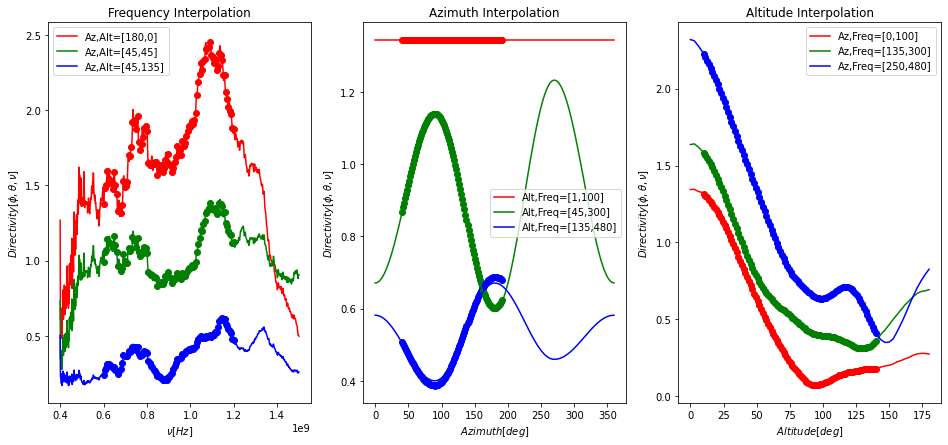

In [840]:
## Now to test interpolation along the axes dimensions of the data:
fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,7))

## Attempt Frequency Interpolation: VERY GOOD AGREEMENT
for i,fr in enumerate(np.linspace(600e6,1200e6,100)):
    tp=np.array([180,0,fr])
    ax1.plot(fr,interpn(points, D_ptf_t, tp),'ro')
    tp=np.array([45,45,fr])
    ax1.plot(fr,interpn(points, D_ptf_t, tp),'go')
    tp=np.array([45,135,fr])
    ax1.plot(fr,interpn(points, D_ptf_t, tp),'bo')
ax1.plot(data.freq,D_ptf_t[180,0,:],'r',label='Az,Alt=[180,0]')
ax1.plot(data.freq,D_ptf_t[45,45,:],'g',label='Az,Alt=[45,45]')
ax1.plot(data.freq,D_ptf_t[45,135,:],'b',label='Az,Alt=[45,135]')
ax1.set_title('Frequency Interpolation')
ax1.set_ylabel(r'$Directivity[\phi,\theta,\nu]$')
ax1.set_xlabel(r'$\nu[Hz]$')
ax1.legend()

## Attempt Azimuth Interpolation: PRETTY GOOD AGREEMENT
for i,azz in enumerate(np.linspace(40,191,100)):
    tp=np.array([azz,0,data.freq[100]])
    ax2.plot(azz,interpn(points, D_ptf_t, tp),'ro')
    tp=np.array([azz,45,data.freq[300]])
    ax2.plot(azz,interpn(points, D_ptf_t, tp),'go')
    tp=np.array([azz,135,data.freq[480]])
    ax2.plot(azz,interpn(points, D_ptf_t, tp),'bo')
ax2.plot(azimuth,D_ptf_t[:,0,100],'r',label='Alt,Freq=[1,100]')
ax2.plot(azimuth,D_ptf_t[:,45,300],'g',label='Alt,Freq=[45,300]')
ax2.plot(azimuth,D_ptf_t[:,135,480],'b',label='Alt,Freq=[135,480]')
ax2.set_title('Azimuth Interpolation')
ax2.set_ylabel(r'$Directivity[\phi,\theta,\nu]$')
ax2.set_xlabel(r'$Azimuth [deg]$')
ax2.legend()

## Attempt Azimuth Interpolation: VERY GOOD AGREEMENT
for i,aalt in enumerate(np.linspace(10,140,100)):
    tp=np.array([1,aalt,data.freq[100]])
    ax3.plot(aalt,interpn(points, D_ptf_t, tp),'ro')
    tp=np.array([135,aalt,data.freq[300]])
    ax3.plot(aalt,interpn(points, D_ptf_t, tp),'go')
    tp=np.array([250,aalt,data.freq[480]])
    ax3.plot(aalt,interpn(points, D_ptf_t, tp),'bo')
ax3.plot(altitude,D_ptf_t[1,:,100],'r',label='Az,Freq=[0,100]')
ax3.plot(altitude,D_ptf_t[135,:,300],'g',label='Az,Freq=[135,300]')
ax3.plot(altitude,D_ptf_t[250,:,480],'b',label='Az,Freq=[250,480]')
ax3.set_title('Altitude Interpolation')
ax3.set_ylabel(r'$Directivity[\phi,\theta,\nu]$')
ax3.set_xlabel(r'$Altitude [deg]$')
ax3.legend()

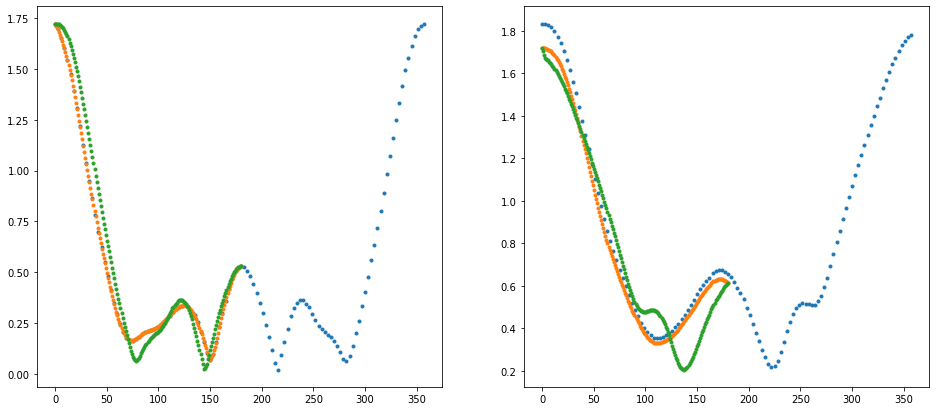

In [843]:
fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,7))
ax1.plot(data.angle,np.absolute(data.complex_E_beam[:,400]),'.')
ax1.plot(altitude,D_ptf_t[0,:,400],'.')
ax1.plot(altitude,D_ptf_t[180,:,400],'.')
ax2.plot(data.angle,np.absolute(data.complex_H_beam[:,400]),'.')
ax2.plot(altitude,D_ptf_t[90,:,400],'.')
ax2.plot(altitude,D_ptf_t[270,:,400],'.')

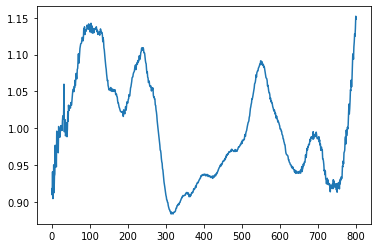

In [8]:
## How much is the normalization factor messing with the data?:
    #I'm pretty convinced my normalization method isn't complete trash, the data still seem distinct enough.
    #The H data still has features that look unique relative to the x data.
plot(np.absolute(data.complex_E_beam[0,:])/np.absolute(data.complex_H_beam[0,:]))

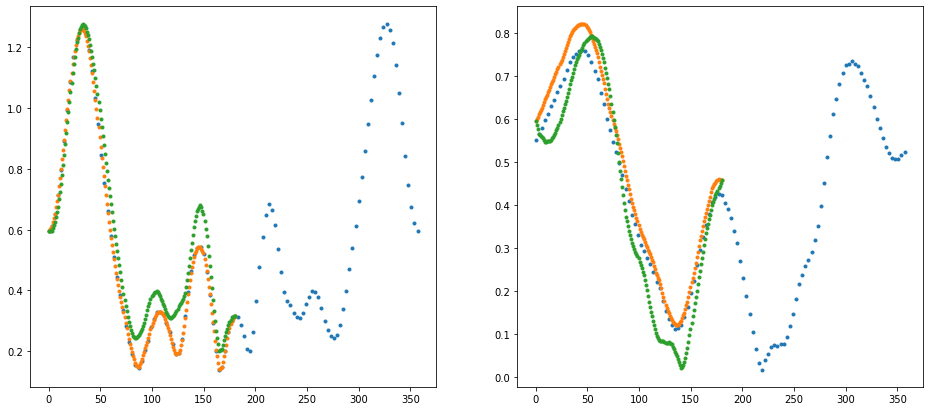

In [16]:
fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,7))
ax1.plot(data.df_angle,np.absolute(data.complex_E_beam[:,790]),'.')
ax1.plot(data.altitude,data.D_ptf_t[0,:,790],'.')
ax1.plot(data.altitude,data.D_ptf_t[180,:,790],'.')
ax2.plot(data.df_angle,np.absolute(data.complex_H_beam[:,790]),'.')
ax2.plot(data.altitude,data.D_ptf_t[90,:,790],'.')
ax2.plot(data.altitude,data.D_ptf_t[270,:,790],'.')

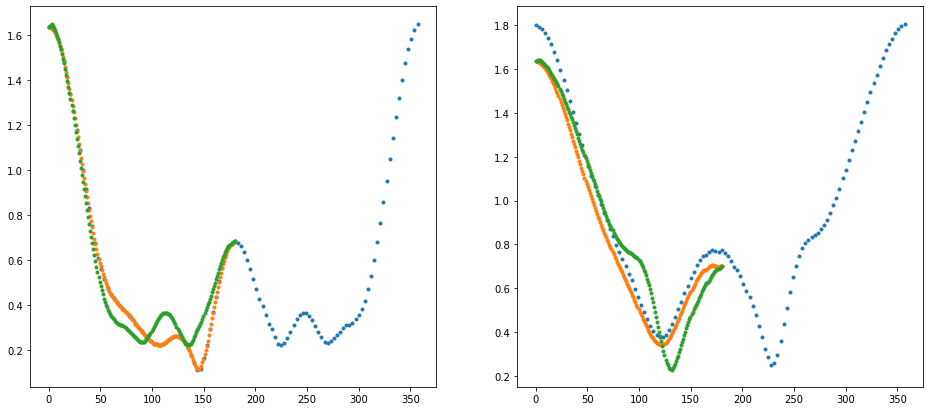

In [17]:
fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,7))
ax1.plot(data.df_angle,np.absolute(data.complex_E_beam[:,300]),'.')
ax1.plot(data.altitude,data.D_ptf_t[0,:,300],'.')
ax1.plot(data.altitude,data.D_ptf_t[180,:,300],'.')
ax2.plot(data.df_angle,np.absolute(data.complex_H_beam[:,300]),'.')
ax2.plot(data.altitude,data.D_ptf_t[90,:,300],'.')
ax2.plot(data.altitude,data.D_ptf_t[270,:,300],'.')